In [1]:
import os
import torch
import pandas as pd
import numpy as np
import optuna
from optuna.pruners import MedianPruner
from optuna.samplers import TPESampler
from transformers import (
AutoTokenizer, AutoModelForMaskedLM, DataCollatorForLanguageModeling,
Trainer, TrainingArguments,
)
from datasets import Dataset
from typing import List, Dict, Optional
import altair as alt

from optuna.integration import TFKerasPruningCallback
from transformers.integrations import TensorBoardCallback

from src.baseline.baseline import train_df, figures_root
from src.finetune.finetuner import main
from src.baseline.utils import calculate_class_distribution, set_all_seeds, SEED

set_all_seeds()


2025-12-03 18:56:03.070529: I tensorflow/core/util/port.cc:153] oneDNN custom operations are on. You may see slightly different numerical results due to floating-point round-off errors from different computation orders. To turn them off, set the environment variable `TF_ENABLE_ONEDNN_OPTS=0`.
2025-12-03 18:56:03.097274: I tensorflow/core/platform/cpu_feature_guard.cc:210] This TensorFlow binary is optimized to use available CPU instructions in performance-critical operations.
To enable the following instructions: AVX2 AVX_VNNI FMA, in other operations, rebuild TensorFlow with the appropriate compiler flags.
2025-12-03 18:56:03.611472: I tensorflow/core/util/port.cc:153] oneDNN custom operations are on. You may see slightly different numerical results due to floating-point round-off errors from different computation orders. To turn them off, set the environment variable `TF_ENABLE_ONEDNN_OPTS=0`.


✓ All random seeds set to 42
training files: ['train_en.csv', 'train_it.csv', 'train_es.csv']
Total training samples: 2988
CLASS DISTRIBUTION

Overall:
  Class 0 (NOT_RECLAMATORY): 2560 (85.7%)
  Class 1 (RECLAMATORY): 428 (14.3%)
  Total: 2988

Per Language:
  EN: Class 0=938, Class 1=88, Total=1026
  ES: Class 0=743, Class 1=133, Total=876
  IT: Class 0=879, Class 1=207, Total=1086


✓ All random seeds set to 42


# Loading Data

In [2]:
original_data = train_df
augmented_data = pd.read_csv("../data/augmented_multilingual_tweets.csv")
print(original_data.shape, augmented_data.shape)

(2988, 5) (5976, 8)


In [3]:
test_root = "../data/test_sets/Test Set/"
test_files = [file for file in os.listdir(test_root) if (file.endswith(".csv") and ("test" in file))]
print(f"training files: {test_files}")

test_df = pd.DataFrame()


for file in test_files:
    temp_df = pd.read_csv(os.path.join(test_root, file))
    if "en" in file:
        temp_df["bio"] = [None] * temp_df.shape[0]
    test_df = pd.concat([test_df, temp_df], ignore_index=True)

training files: ['es_test.csv', 'it_test.csv', 'en_test.csv']


In [4]:
test_df["label"] = ["NA"] * test_df.shape[0]
test_df

,id,text,bio,lang,label
0,es_135,@USER @USER @USER @USER @USER @USER @USER La l...,"Pronouns: MAN XY\nANTI IDEOLOGÍA TRANS, QUEER ...",es,NA
1,es_1694,"""En las calles o en los balcones, seguiremos s...","PhD, HBS. Biotecnólogo en #innovación y #scipo...",es,NA
2,es_1558,"@USER A mí, la verdad, lo que me parece increí...",Persona transedad. Jubilada sentida oprimida p...,es,NA
3,es_997,. @USER Felicitaciones por la forma de present...,Jazz y DDHH. Lic. en CC de la Comunicación. Es...,es,NA
4,es_168,"Por lo que sea, las que tanto hablan de abolic...",Soi yo.,es,NA
...,...,...,...,...,...
1990,en_1646,@USER pussy you can't fight &#128564;,None,en,NA
1991,en_1421,"&gt; ... (""they don't want us trannies breedin...",None,en,NA
1992,en_408,I understand that in India this form of passiv...,None,en,NA
1993,en_747,"I find that people use ""faggot"" a lot more the...",None,en,NA


In [5]:
merged_data = pd.concat([original_data, augmented_data[list(original_data.columns)]], ignore_index=True)
print(merged_data.shape)
merged_data_1 = pd.concat([merged_data, test_df], ignore_index=True)
print(merged_data_1.shape)

(8964, 5)
(10959, 5)


# Initial Model Configuration

In [6]:
class MLMConfig:
    MODEL_NAME = "cardiffnlp/twitter-xlm-roberta-base"
    OUTPUT_DIR = "../fine_tuned_models/mlm_twitter_xlm_roberta_optuna"
    TEXT_COLUMN = "text"
    MAX_LENGTH = 128
    TRAIN_TEST_SPLIT = 0.05
    SEED = SEED
    DEVICE = torch.device("cuda" if torch.cuda.is_available() else "cpu")
    NUM_FROZEN_LAYERS = 10

In [7]:
config = MLMConfig
os.makedirs(config.OUTPUT_DIR, exist_ok=True)

print(f"Device: {config.DEVICE}")
print(f"Output directory: {config.OUTPUT_DIR}")

Device: cuda
Output directory: ../fine_tuned_models/mlm_twitter_xlm_roberta_optuna


# Data Preparation

In [8]:
print(f"Total samples: {len(merged_data_1)}")
print(f"Columns: {merged_data_1.columns.tolist()}")

texts = merged_data_1[config.TEXT_COLUMN].tolist()
texts = [str(text).strip() for text in texts if pd.notna(text) and str(text).strip()]

print(f"After cleaning: {len(texts)} samples")

dataset = Dataset.from_dict({"text": texts})
print(f"Dataset created: {len(dataset)} samples")

Total samples: 10959
Columns: ['id', 'text', 'label', 'lang', 'bio']
After cleaning: 10959 samples
Dataset created: 10959 samples


In [9]:
tokenizer = AutoTokenizer.from_pretrained(config.MODEL_NAME)

def tokenize_function(examples):
    return tokenizer(
    examples["text"],
    truncation=True,
    max_length=config.MAX_LENGTH,
    padding="max_length",
    return_special_tokens_mask=True,
    )

tokenized_dataset = dataset.map(
tokenize_function,
batched=True,
remove_columns=["text"],
desc="Tokenizing texts"
)

print(f"Tokenized dataset created")
print(f"Sample tokenized entry keys: {list(tokenized_dataset[0].keys())}")  # ✓ Fixed
print(f"Dataset columns: {tokenized_dataset.column_names}")

split_dataset = tokenized_dataset.train_test_split(test_size=0.05, seed=SEED)
print(f"Train samples: {len(split_dataset['train'])}")
print(f"Validation samples: {len(split_dataset['test'])}")

Tokenizing texts:   0%|          | 0/10959 [00:00<?, ? examples/s]

Tokenized dataset created
Sample tokenized entry keys: ['input_ids', 'attention_mask', 'special_tokens_mask']
Dataset columns: ['input_ids', 'attention_mask', 'special_tokens_mask']
Train samples: 10411
Validation samples: 548


In [10]:
def freeze_encoder_layers(model, num_frozen_layers):
    """
    Freeze the first num_frozen_layers in the encoder.
    Only the last (12 - num_frozen_layers) layers will be trained.
    
    For XLM-RoBERTa with 12 layers:
    - num_frozen_layers=10 → freeze first 10, train last 2 + head
    - num_frozen_layers=11 → freeze first 11, train only last 1 + head
    - num_frozen_layers=12 → freeze all, train only head
    """
    
    # Freeze embeddings (always recommended)
    for param in model.roberta.embeddings.parameters():
        param.requires_grad = False
    
    # Freeze specified number of encoder layers
    total_layers = len(model.roberta.encoder.layer)
    
    for layer_idx in range(num_frozen_layers):
        for param in model.roberta.encoder.layer[layer_idx].parameters():
            param.requires_grad = False
    
    # Count trainable parameters
    trainable_params = sum(p.numel() for p in model.parameters() if p.requires_grad)
    total_params = sum(p.numel() for p in model.parameters())
    trainable_pct = (trainable_params / total_params) * 100
    
    print(f"\n{'='*80}")
    print(f"LAYER FREEZING CONFIGURATION")
    print(f"{'='*80}")
    print(f"Total layers: {total_layers}")
    print(f"Frozen layers: {num_frozen_layers} (layers 0-{num_frozen_layers-1})")
    print(f"Trainable layers: {total_layers - num_frozen_layers} (layers {num_frozen_layers}-{total_layers-1})")
    print(f"Trainable parameters: {trainable_params:,} / {total_params:,} ({trainable_pct:.2f}%)")
    print(f"{'='*80}\n")
    
    return model

# Optuna Hyperparameter Selection

In [11]:
def objective(trial):
    learning_rate = trial.suggest_loguniform("learning_rate", 1e-5, 5e-4)
    weight_decay = trial.suggest_float("weight_decay", 0.0, 0.1)
    warmup_ratio = trial.suggest_float("warmup_ratio", 0.0, 0.3)
    mlm_probability = trial.suggest_float("mlm_probability", 0.10, 0.25)
    batch_size = trial.suggest_categorical("batch_size", [8, 16, 32])
    num_epochs = trial.suggest_int("num_epochs", 3, 8)
    gradient_accumulation = trial.suggest_int("gradient_accumulation_steps", 1, 4)
    
    print(f"\n{'='*80}")
    print(f"Trial {trial.number}")
    print(f"{'='*80}")
    print(f"Learning rate: {learning_rate:.2e}")
    print(f"Weight decay: {weight_decay:.4f}")
    print(f"Warmup ratio: {warmup_ratio:.4f}")
    print(f"MLM probability: {mlm_probability:.4f}")
    print(f"Batch size: {batch_size}")
    print(f"Epochs: {num_epochs}")
    print(f"Gradient accumulation: {gradient_accumulation}")
    
    trial_output_dir = os.path.join(config.OUTPUT_DIR, f"trial_{trial.number}")
    os.makedirs(trial_output_dir, exist_ok=True)

    model = AutoModelForMaskedLM.from_pretrained(config.MODEL_NAME)

    model = freeze_encoder_layers(model, config.NUM_FROZEN_LAYERS)
    
    data_collator = DataCollatorForLanguageModeling(
        tokenizer=tokenizer,
        mlm_probability=mlm_probability,
    )

    training_args = TrainingArguments(
        output_dir=trial_output_dir,
        num_train_epochs=num_epochs,
        per_device_train_batch_size=batch_size,
        per_device_eval_batch_size=batch_size * 2,
        learning_rate=learning_rate,
        weight_decay=weight_decay,
        warmup_ratio=warmup_ratio,
        gradient_accumulation_steps=gradient_accumulation,
        save_strategy="epoch",
        eval_strategy="epoch",
        logging_steps=50,
        seed=config.SEED,
        fp16=torch.cuda.is_available(),
        load_best_model_at_end=True,
        metric_for_best_model="eval_loss",
        greater_is_better=False,
        report_to=[],
    )
    
    trainer = Trainer(
        model=model,
        args=training_args,
        data_collator=data_collator,
        train_dataset=split_dataset["train"],
        eval_dataset=split_dataset["test"],
        tokenizer=tokenizer,
    )
    
    trainer.add_callback(OptunaCallback(trial))
    
    try:
        train_result = trainer.train()
        
        eval_results = trainer.evaluate()
        eval_loss = eval_results["eval_loss"]
        
        print(f"Final eval loss: {eval_loss:.4f}")
    
        import shutil
        shutil.rmtree(trial_output_dir, ignore_errors=True)
        
        return eval_loss
        
    except Exception as e:
        print(f"Trial {trial.number} failed: {str(e)}")
        return float("inf")
    

In [12]:
class OptunaCallback(TensorBoardCallback):
    def __init__(self, trial):
        super().__init__()
        self.trial = trial
        self.step = 0

    def on_evaluate(self, args, state, control, metrics=None, **kwargs):
        if metrics is None:
            return
        
        eval_loss = metrics.get("eval_loss", None)
        if eval_loss is None:
            return
        
        self.step = state.global_step
        
        self.trial.report(eval_loss, self.step)
        
        if self.trial.should_prune():
            print(f"Trial pruned at step {self.step} with eval_loss: {eval_loss:.4f}")
            raise optuna.TrialPruned()

In [13]:
sampler = TPESampler(seed=config.SEED)
pruner = MedianPruner(n_startup_trials=3, n_warmup_steps=100)

study = optuna.create_study(
direction="minimize",
sampler=sampler,
pruner=pruner,
study_name="mlm_optimization"
)

n_trials = 15

study.optimize(
objective,
n_trials=n_trials,
timeout=None, # No timeout
gc_after_trial=True,
show_progress_bar=True
)

best_trial = study.best_trial

print(f"\nBest trial: {best_trial.number}")
print(f"Best eval_loss: {best_trial.value:.4f}")
print(f"\nBest hyperparameters:")
for key, value in best_trial.params.items():
    print(f" {key}: {value}")

trials_df = study.trials_dataframe()
trials_df = trials_df.sort_values("value")

print(f"\n\nTop 5 Trials:")
print(trials_df[["number", "value", "params_learning_rate", "params_batch_size",
"params_num_epochs"]].head(5).to_string())

results_file = os.path.join(config.OUTPUT_DIR, "optuna_results.csv")
trials_df.to_csv(results_file, index=False)
print(f"\nResults saved to: {results_file}")

[I 2025-12-03 18:56:06,836] A new study created in memory with name: mlm_optimization


  0%|          | 0/15 [00:00<?, ?it/s]


Trial 0
Learning rate: 4.33e-05
Weight decay: 0.0951
Warmup ratio: 0.2196
MLM probability: 0.1898
Batch size: 8
Epochs: 8
Gradient accumulation: 3

LAYER FREEZING CONFIGURATION
Total layers: 12
Frozen layers: 10 (layers 0-9)
Trainable layers: 2 (layers 10-11)
Trainable parameters: 15,017,874 / 278,295,186 (5.40%)



Epoch,Training Loss,Validation Loss
1,3.159300,2.688515
2,3.003900,2.649006
3,2.851800,2.655664
4,2.756400,2.568434
5,2.770800,2.539624
6,2.769800,2.463860
7,2.711200,2.437675
8,2.727300,2.416970


There were missing keys in the checkpoint model loaded: ['lm_head.decoder.weight', 'lm_head.decoder.bias'].


Final eval loss: 2.4323
[I 2025-12-03 19:08:10,300] Trial 0 finished with value: 2.4322550296783447 and parameters: {'learning_rate': 4.3284502212938785e-05, 'weight_decay': 0.09507143064099162, 'warmup_ratio': 0.21959818254342153, 'mlm_probability': 0.1897987726295555, 'batch_size': 8, 'num_epochs': 8, 'gradient_accumulation_steps': 3}. Best is trial 0 with value: 2.4322550296783447.

Trial 1
Learning rate: 1.60e-04
Weight decay: 0.0021
Warmup ratio: 0.2910
MLM probability: 0.2249
Batch size: 8
Epochs: 4
Gradient accumulation: 3

LAYER FREEZING CONFIGURATION
Total layers: 12
Frozen layers: 10 (layers 0-9)
Trainable layers: 2 (layers 10-11)
Trainable parameters: 15,017,874 / 278,295,186 (5.40%)



Epoch,Training Loss,Validation Loss
1,3.203500,2.808615
2,3.034400,2.710131
3,2.850400,2.670030
4,2.750600,2.592071


There were missing keys in the checkpoint model loaded: ['lm_head.decoder.weight', 'lm_head.decoder.bias'].


Final eval loss: 2.6006
[I 2025-12-03 19:14:13,316] Trial 1 finished with value: 2.6005663871765137 and parameters: {'learning_rate': 0.00015958573588141273, 'weight_decay': 0.0020584494295802446, 'warmup_ratio': 0.29097295564859826, 'mlm_probability': 0.22486639612006326, 'batch_size': 8, 'num_epochs': 4, 'gradient_accumulation_steps': 3}. Best is trial 0 with value: 2.4322550296783447.

Trial 2
Learning rate: 5.42e-05
Weight decay: 0.0291
Warmup ratio: 0.1836
MLM probability: 0.1209
Batch size: 32
Epochs: 7
Gradient accumulation: 1

LAYER FREEZING CONFIGURATION
Total layers: 12
Frozen layers: 10 (layers 0-9)
Trainable layers: 2 (layers 10-11)
Trainable parameters: 15,017,874 / 278,295,186 (5.40%)



Epoch,Training Loss,Validation Loss
1,2.899500,2.512215
2,2.722700,2.332584
3,2.655100,2.302676
4,2.562500,2.242547
5,2.597600,2.282782
6,2.483800,2.246836
7,2.582700,2.250143


There were missing keys in the checkpoint model loaded: ['lm_head.decoder.weight', 'lm_head.decoder.bias'].


Final eval loss: 2.3527
[I 2025-12-03 19:19:30,330] Trial 2 finished with value: 2.352747678756714 and parameters: {'learning_rate': 5.4182823195332406e-05, 'weight_decay': 0.029122914019804193, 'warmup_ratio': 0.18355586841671384, 'mlm_probability': 0.12092407909780628, 'batch_size': 32, 'num_epochs': 7, 'gradient_accumulation_steps': 1}. Best is trial 2 with value: 2.352747678756714.

Trial 3
Learning rate: 7.48e-05
Weight decay: 0.0592
Warmup ratio: 0.0139
MLM probability: 0.1911
Batch size: 32
Epochs: 8
Gradient accumulation: 4

LAYER FREEZING CONFIGURATION
Total layers: 12
Frozen layers: 10 (layers 0-9)
Trainable layers: 2 (layers 10-11)
Trainable parameters: 15,017,874 / 278,295,186 (5.40%)



Epoch,Training Loss,Validation Loss
1,3.257200,2.668973
2,2.954400,2.586543
3,2.925800,2.552975
4,2.878400,2.528948
5,2.841600,2.517533
6,2.803000,2.555396
7,2.806100,2.492044
8,2.766100,2.436573


There were missing keys in the checkpoint model loaded: ['lm_head.decoder.weight', 'lm_head.decoder.bias'].


Final eval loss: 2.5167
[I 2025-12-03 19:25:24,530] Trial 3 finished with value: 2.516744613647461 and parameters: {'learning_rate': 7.475992999956501e-05, 'weight_decay': 0.05924145688620425, 'warmup_ratio': 0.013935123815999317, 'mlm_probability': 0.19113172778521575, 'batch_size': 32, 'num_epochs': 8, 'gradient_accumulation_steps': 4}. Best is trial 2 with value: 2.352747678756714.

Trial 4
Learning rate: 3.29e-05
Weight decay: 0.0098
Warmup ratio: 0.2053
MLM probability: 0.1660
Batch size: 16
Epochs: 8
Gradient accumulation: 2

LAYER FREEZING CONFIGURATION
Total layers: 12
Frozen layers: 10 (layers 0-9)
Trainable layers: 2 (layers 10-11)
Trainable parameters: 15,017,874 / 278,295,186 (5.40%)



Epoch,Training Loss,Validation Loss
1,3.086200,2.666678


Trial pruned at step 326 with eval_loss: 2.6667
Trial 4 failed: 
[I 2025-12-03 19:26:25,553] Trial 4 finished with value: inf and parameters: {'learning_rate': 3.292529363110524e-05, 'weight_decay': 0.009767211400638388, 'warmup_ratio': 0.20526990795364705, 'mlm_probability': 0.16602287406094018, 'batch_size': 16, 'num_epochs': 8, 'gradient_accumulation_steps': 2}. Best is trial 2 with value: 2.352747678756714.

Trial 5
Learning rate: 1.34e-04
Weight decay: 0.0312
Warmup ratio: 0.1560
MLM probability: 0.1820
Batch size: 16
Epochs: 8
Gradient accumulation: 4

LAYER FREEZING CONFIGURATION
Total layers: 12
Frozen layers: 10 (layers 0-9)
Trainable layers: 2 (layers 10-11)
Trainable parameters: 15,017,874 / 278,295,186 (5.40%)



Epoch,Training Loss,Validation Loss
1,3.034700,2.658264
2,2.909100,2.549574
3,2.854800,2.550471
4,2.761800,2.419783


Trial pruned at step 652 with eval_loss: 2.4198
Trial 5 failed: 
[I 2025-12-03 19:30:19,850] Trial 5 finished with value: inf and parameters: {'learning_rate': 0.00013353819088790598, 'weight_decay': 0.031171107608941095, 'warmup_ratio': 0.15602040635334324, 'mlm_probability': 0.18200654190149196, 'batch_size': 16, 'num_epochs': 8, 'gradient_accumulation_steps': 4}. Best is trial 2 with value: 2.352747678756714.

Trial 6
Learning rate: 1.04e-04
Weight decay: 0.0922
Warmup ratio: 0.0265
MLM probability: 0.1294
Batch size: 32
Epochs: 4
Gradient accumulation: 4

LAYER FREEZING CONFIGURATION
Total layers: 12
Frozen layers: 10 (layers 0-9)
Trainable layers: 2 (layers 10-11)
Trainable parameters: 15,017,874 / 278,295,186 (5.40%)



Epoch,Training Loss,Validation Loss
1,3.005500,2.469272
2,2.726600,2.336959
3,2.686300,2.367515
4,2.651100,2.275169


There were missing keys in the checkpoint model loaded: ['lm_head.decoder.weight', 'lm_head.decoder.bias'].


Final eval loss: 2.3960
[I 2025-12-03 19:33:18,236] Trial 6 finished with value: 2.3960134983062744 and parameters: {'learning_rate': 0.0001037084466895453, 'weight_decay': 0.09218742350231168, 'warmup_ratio': 0.02654775061557585, 'mlm_probability': 0.1293974293628718, 'batch_size': 32, 'num_epochs': 4, 'gradient_accumulation_steps': 4}. Best is trial 2 with value: 2.352747678756714.

Trial 7
Learning rate: 4.04e-05
Weight decay: 0.0281
Warmup ratio: 0.1628
MLM probability: 0.1211
Batch size: 32
Epochs: 7
Gradient accumulation: 1

LAYER FREEZING CONFIGURATION
Total layers: 12
Frozen layers: 10 (layers 0-9)
Trainable layers: 2 (layers 10-11)
Trainable parameters: 15,017,874 / 278,295,186 (5.40%)



Epoch,Training Loss,Validation Loss
1,2.912300,2.525533
2,2.735200,2.346092
3,2.676700,2.325270


Trial pruned at step 978 with eval_loss: 2.3253
Trial 7 failed: 
[I 2025-12-03 19:35:34,198] Trial 7 finished with value: inf and parameters: {'learning_rate': 4.0375061884407564e-05, 'weight_decay': 0.02809345096873808, 'warmup_ratio': 0.16280882494747453, 'mlm_probability': 0.1211386337462144, 'batch_size': 32, 'num_epochs': 7, 'gradient_accumulation_steps': 1}. Best is trial 2 with value: 2.352747678756714.

Trial 8
Learning rate: 1.02e-05
Weight decay: 0.0815
Warmup ratio: 0.2121
MLM probability: 0.2094
Batch size: 8
Epochs: 3
Gradient accumulation: 4

LAYER FREEZING CONFIGURATION
Total layers: 12
Frozen layers: 10 (layers 0-9)
Trainable layers: 2 (layers 10-11)
Trainable parameters: 15,017,874 / 278,295,186 (5.40%)



Epoch,Training Loss,Validation Loss
1,3.283900,2.864359


Trial pruned at step 326 with eval_loss: 2.8644
Trial 8 failed: 
[I 2025-12-03 19:37:04,483] Trial 8 finished with value: inf and parameters: {'learning_rate': 1.0218376758008082e-05, 'weight_decay': 0.08154614284548342, 'warmup_ratio': 0.21205720315428514, 'mlm_probability': 0.2093510752061481, 'batch_size': 8, 'num_epochs': 3, 'gradient_accumulation_steps': 4}. Best is trial 2 with value: 2.352747678756714.

Trial 9
Learning rate: 1.15e-04
Weight decay: 0.0331
Warmup ratio: 0.0191
MLM probability: 0.1466
Batch size: 16
Epochs: 8
Gradient accumulation: 2

LAYER FREEZING CONFIGURATION
Total layers: 12
Frozen layers: 10 (layers 0-9)
Trainable layers: 2 (layers 10-11)
Trainable parameters: 15,017,874 / 278,295,186 (5.40%)



Epoch,Training Loss,Validation Loss
1,2.853400,2.481250
2,2.713100,2.388678


Trial pruned at step 652 with eval_loss: 2.3887
Trial 9 failed: 
[I 2025-12-03 19:39:04,039] Trial 9 finished with value: inf and parameters: {'learning_rate': 0.0001145420156259939, 'weight_decay': 0.03308980248526492, 'warmup_ratio': 0.01906750508580709, 'mlm_probability': 0.14664734825734932, 'batch_size': 16, 'num_epochs': 8, 'gradient_accumulation_steps': 2}. Best is trial 2 with value: 2.352747678756714.

Trial 10
Learning rate: 4.03e-04
Weight decay: 0.0564
Warmup ratio: 0.0923
MLM probability: 0.1027
Batch size: 32
Epochs: 6
Gradient accumulation: 1

LAYER FREEZING CONFIGURATION
Total layers: 12
Frozen layers: 10 (layers 0-9)
Trainable layers: 2 (layers 10-11)
Trainable parameters: 15,017,874 / 278,295,186 (5.40%)



Epoch,Training Loss,Validation Loss
1,2.943400,2.542530


Trial pruned at step 326 with eval_loss: 2.5425
Trial 10 failed: 
[I 2025-12-03 19:39:49,868] Trial 10 finished with value: inf and parameters: {'learning_rate': 0.0004034211273268901, 'weight_decay': 0.05644258738443207, 'warmup_ratio': 0.09230826343507867, 'mlm_probability': 0.10269428134222296, 'batch_size': 32, 'num_epochs': 6, 'gradient_accumulation_steps': 1}. Best is trial 2 with value: 2.352747678756714.

Trial 11
Learning rate: 2.00e-05
Weight decay: 0.0745
Warmup ratio: 0.0942
MLM probability: 0.1415
Batch size: 32
Epochs: 5
Gradient accumulation: 2

LAYER FREEZING CONFIGURATION
Total layers: 12
Frozen layers: 10 (layers 0-9)
Trainable layers: 2 (layers 10-11)
Trainable parameters: 15,017,874 / 278,295,186 (5.40%)



Epoch,Training Loss,Validation Loss
1,3.028000,2.599825
2,2.841300,2.497761
3,2.871300,2.488075
4,2.811000,2.421388


Trial pruned at step 652 with eval_loss: 2.4214
Trial 11 failed: 
[I 2025-12-03 19:42:46,642] Trial 11 finished with value: inf and parameters: {'learning_rate': 1.9980224504081465e-05, 'weight_decay': 0.07446608994507356, 'warmup_ratio': 0.09421788910519172, 'mlm_probability': 0.14150549861139472, 'batch_size': 32, 'num_epochs': 5, 'gradient_accumulation_steps': 2}. Best is trial 2 with value: 2.352747678756714.

Trial 12
Learning rate: 2.85e-04
Weight decay: 0.0402
Warmup ratio: 0.0928
MLM probability: 0.1013
Batch size: 32
Epochs: 5
Gradient accumulation: 3

LAYER FREEZING CONFIGURATION
Total layers: 12
Frozen layers: 10 (layers 0-9)
Trainable layers: 2 (layers 10-11)
Trainable parameters: 15,017,874 / 278,295,186 (5.40%)



Epoch,Training Loss,Validation Loss
1,2.796400,2.391154
2,2.598300,2.275992
3,2.573800,2.212046
4,2.463500,2.089645
5,2.389600,2.180711


There were missing keys in the checkpoint model loaded: ['lm_head.decoder.weight', 'lm_head.decoder.bias'].


Final eval loss: 2.1668
[I 2025-12-03 19:46:29,600] Trial 12 finished with value: 2.1667520999908447 and parameters: {'learning_rate': 0.00028549700518189783, 'weight_decay': 0.0402381931529963, 'warmup_ratio': 0.0927503212611811, 'mlm_probability': 0.10134403486517332, 'batch_size': 32, 'num_epochs': 5, 'gradient_accumulation_steps': 3}. Best is trial 12 with value: 2.1667520999908447.

Trial 13
Learning rate: 4.71e-04
Weight decay: 0.0416
Warmup ratio: 0.0994
MLM probability: 0.1022
Batch size: 32
Epochs: 6
Gradient accumulation: 3

LAYER FREEZING CONFIGURATION
Total layers: 12
Frozen layers: 10 (layers 0-9)
Trainable layers: 2 (layers 10-11)
Trainable parameters: 15,017,874 / 278,295,186 (5.40%)



Epoch,Training Loss,Validation Loss
1,2.849000,2.449691


Trial pruned at step 109 with eval_loss: 2.4497
Trial 13 failed: 
[I 2025-12-03 19:47:14,722] Trial 13 finished with value: inf and parameters: {'learning_rate': 0.0004712887166138999, 'weight_decay': 0.04158376075844615, 'warmup_ratio': 0.09940714377356256, 'mlm_probability': 0.10221151510189941, 'batch_size': 32, 'num_epochs': 6, 'gradient_accumulation_steps': 3}. Best is trial 12 with value: 2.1667520999908447.

Trial 14
Learning rate: 2.75e-04
Weight decay: 0.0162
Warmup ratio: 0.1224
MLM probability: 0.1193
Batch size: 32
Epochs: 5
Gradient accumulation: 1

LAYER FREEZING CONFIGURATION
Total layers: 12
Frozen layers: 10 (layers 0-9)
Trainable layers: 2 (layers 10-11)
Trainable parameters: 15,017,874 / 278,295,186 (5.40%)



Epoch,Training Loss,Validation Loss
1,2.900000,2.533023
2,2.691100,2.343342
3,2.564000,2.270856
4,2.439500,2.185739
5,2.439200,2.213822


There were missing keys in the checkpoint model loaded: ['lm_head.decoder.weight', 'lm_head.decoder.bias'].


Final eval loss: 2.1967
[I 2025-12-03 19:51:02,481] Trial 14 finished with value: 2.196707010269165 and parameters: {'learning_rate': 0.0002748027075767293, 'weight_decay': 0.01621254730592113, 'warmup_ratio': 0.12235764958648637, 'mlm_probability': 0.1193064955294735, 'batch_size': 32, 'num_epochs': 5, 'gradient_accumulation_steps': 1}. Best is trial 12 with value: 2.1667520999908447.

Best trial: 12
Best eval_loss: 2.1668

Best hyperparameters:
 learning_rate: 0.00028549700518189783
 weight_decay: 0.0402381931529963
 warmup_ratio: 0.0927503212611811
 mlm_probability: 0.10134403486517332
 batch_size: 32
 num_epochs: 5
 gradient_accumulation_steps: 3


Top 5 Trials:
    number     value  params_learning_rate  params_batch_size  params_num_epochs
12      12  2.166752              0.000285                 32                  5
14      14  2.196707              0.000275                 32                  5
2        2  2.352748              0.000054                 32                  7
6

# Visualize Optimization Process

In [14]:
import matplotlib.pyplot as plt

Visualization saved!


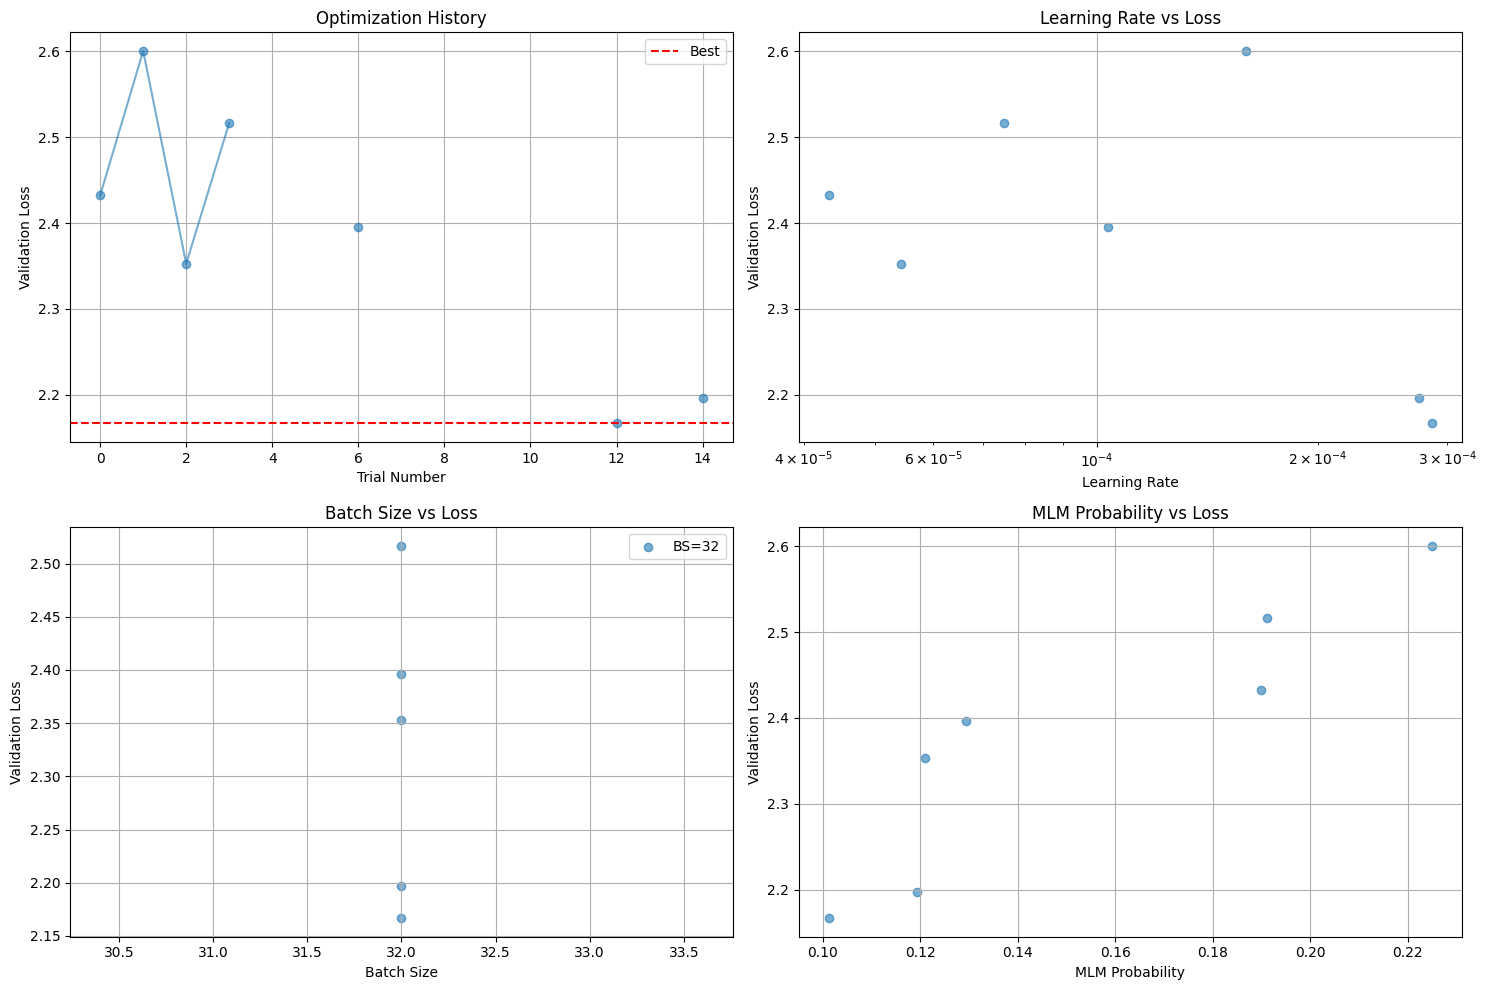

In [15]:
fig, axes = plt.subplots(2, 2, figsize=(15, 10))
ax = axes[0, 0]
trial_numbers = [t.number for t in study.trials]
trial_values = [t.value for t in study.trials]
ax.plot(trial_numbers, trial_values, 'o-', alpha=0.6)
ax.axhline(y=study.best_value, color='r', linestyle='--', label='Best')
ax.set_xlabel('Trial Number')
ax.set_ylabel('Validation Loss')
ax.set_title('Optimization History')
ax.legend()
ax.grid(True)

ax = axes[0, 1]
lr_values = [t.params.get("learning_rate", 0) for t in study.trials]
ax.scatter(lr_values, trial_values, alpha=0.6)
ax.set_xlabel('Learning Rate')
ax.set_ylabel('Validation Loss')
ax.set_xscale('log')
ax.set_title('Learning Rate vs Loss')
ax.grid(True)

ax = axes[1, 0]
batch_sizes = [t.params.get("batch_size", 0) for t in study.trials]
batch_loss = [(bs, v) for bs, v in zip(batch_sizes, trial_values)]
for bs in set(batch_sizes):
    losses = [v for b, v in batch_loss if b == bs]
ax.scatter([bs] * len(losses), losses, label=f'BS={bs}', alpha=0.6)
ax.set_xlabel('Batch Size')
ax.set_ylabel('Validation Loss')
ax.set_title('Batch Size vs Loss')
ax.legend()
ax.grid(True)

ax = axes[1, 1]
mlm_values = [t.params.get("mlm_probability", 0) for t in study.trials]
ax.scatter(mlm_values, trial_values, alpha=0.6)
ax.set_xlabel('MLM Probability')
ax.set_ylabel('Validation Loss')
ax.set_title('MLM Probability vs Loss')
ax.grid(True)

plt.tight_layout()
plt.savefig(os.path.join(config.OUTPUT_DIR, "optuna_analysis.png"), dpi=300)
print("Visualization saved!")
plt.show()


# Final MLM Tunning with Best Parameters

In [16]:
best_params = best_trial.params

class BestMLMConfig:
    MODEL_NAME = "cardiffnlp/twitter-xlm-roberta-base"
    OUTPUT_DIR = os.path.join(config.OUTPUT_DIR, "final_MLM_model")
    TEXT_COLUMN = "text"
    MAX_LENGTH = 128

    LEARNING_RATE = best_params["learning_rate"]
    WEIGHT_DECAY = best_params["weight_decay"]
    WARMUP_RATIO = best_params["warmup_ratio"]
    MLM_PROBABILITY = best_params["mlm_probability"]
    BATCH_SIZE = best_params["batch_size"]
    NUM_EPOCHS = best_params["num_epochs"]
    GRADIENT_ACCUMULATION_STEPS = best_params["gradient_accumulation_steps"]
    
    SEED = SEED

    
    DEVICE = torch.device("cuda" if torch.cuda.is_available() else "cpu")

In [17]:
best_config = BestMLMConfig
os.makedirs(best_config.OUTPUT_DIR, exist_ok=True)
model = AutoModelForMaskedLM.from_pretrained(best_config.MODEL_NAME)

model = freeze_encoder_layers(model, config.NUM_FROZEN_LAYERS)

data_collator = DataCollatorForLanguageModeling(
tokenizer=tokenizer,
mlm_probability=best_config.MLM_PROBABILITY,
)


LAYER FREEZING CONFIGURATION
Total layers: 12
Frozen layers: 10 (layers 0-9)
Trainable layers: 2 (layers 10-11)
Trainable parameters: 15,017,874 / 278,295,186 (5.40%)



In [18]:
training_args = TrainingArguments(
output_dir=best_config.OUTPUT_DIR,
num_train_epochs=best_config.NUM_EPOCHS,
per_device_train_batch_size=best_config.BATCH_SIZE,
per_device_eval_batch_size=best_config.BATCH_SIZE * 2,
learning_rate=best_config.LEARNING_RATE,
weight_decay=best_config.WEIGHT_DECAY,
warmup_ratio=best_config.WARMUP_RATIO,
gradient_accumulation_steps=best_config.GRADIENT_ACCUMULATION_STEPS,
save_strategy="epoch",
eval_strategy="epoch",
logging_steps=100,
seed=best_config.SEED,
fp16=torch.cuda.is_available(),
load_best_model_at_end=True,
metric_for_best_model="eval_loss",
greater_is_better=False,
)

In [19]:
final_trainer = Trainer(
model=model,
args=training_args,
data_collator=data_collator,
train_dataset=split_dataset["train"],
eval_dataset=split_dataset["test"],
tokenizer=tokenizer,
)

In [20]:
print("Training final model...")
final_result = final_trainer.train()

Training final model...


Epoch,Training Loss,Validation Loss
1,2.876000,2.391154
2,2.631000,2.275992
3,2.568300,2.212046
4,2.463800,2.089645
5,2.394700,2.180711


There were missing keys in the checkpoint model loaded: ['lm_head.decoder.weight', 'lm_head.decoder.bias'].


In [21]:
final_eval = final_trainer.evaluate()

print(f"\nFinal Model Results:")
print(f"Training loss: {final_result.training_loss:.4f}")
print(f"Validation loss: {final_eval['eval_loss']:.4f}")


Final Model Results:
Training loss: 2.5730
Validation loss: 2.1668


In [22]:
final_model_path = os.path.join(best_config.OUTPUT_DIR, "model")
model.save_pretrained(final_model_path)
tokenizer.save_pretrained(final_model_path)

print(f"Model saved to: {final_model_path}")

Model saved to: ../fine_tuned_models/mlm_twitter_xlm_roberta_optuna/final_MLM_model/model


In [23]:
training_history = final_trainer.state.log_history
results_df = pd.DataFrame(training_history)
results_csv_path = os.path.join(config.OUTPUT_DIR, "mlm_training_results.csv")
results_df.to_csv(results_csv_path, index=False)
print(f"\nTraining history saved to: {results_csv_path}")
results_df = pd.read_csv(results_csv_path)


Training history saved to: ../fine_tuned_models/mlm_twitter_xlm_roberta_optuna/mlm_training_results.csv


In [24]:
train_df = results_df[results_df['loss'].notna()].copy()
eval_df = results_df[results_df['eval_loss'].notna()].copy()

print(f"\nTrain steps: {len(train_df)}")
print(f"Eval steps: {len(eval_df)}")

loss_data = []
if len(train_df) > 0:
    for idx, row in train_df.iterrows():
        loss_data.append({
        "step": int(row["step"]),
        "loss": row["loss"],
        "type": "Training Loss"
        })
        
if len(eval_df) > 0:
    for idx, row in eval_df.iterrows():
        loss_data.append({
        "step": int(row["step"]),
        "loss": row["eval_loss"],
        "type": "Validation Loss"
        })

loss_plot_df = pd.DataFrame(loss_data)


Train steps: 5
Eval steps: 6


In [25]:
loss_plot = alt.Chart(loss_plot_df).mark_line(point=True, size=2).encode(
x=alt.X("step:Q", title="Training Step"),
y=alt.Y("loss:Q", title="Loss", scale=alt.Scale(zero=False)),
color=alt.Color("type:N", title="Loss Type", scale=alt.Scale(scheme="paired")),
tooltip=["step:Q", alt.Tooltip("loss:Q", format=".4f"), "type:N"]
).properties(
width=700,
height=400,
title="MLM Training: Loss Over Steps"
).interactive()

figures_root = "../figures"
os.makedirs(figures_root, exist_ok=True)
loss_plot.save(os.path.join(figures_root, "mlm_loss_over_steps.svg"))
print(f"Loss plot saved to: {os.path.join(figures_root, 'mlm_loss_over_steps.svg')}")

Loss plot saved to: ../figures/mlm_loss_over_steps.svg


![](../figures/mlm_loss_over_steps.svg)